# Курсовая работа
## Задание K-3-07. Расчёт движения автомобиля

### Исходные данные
Автомобиль массы $M$, поддерживаемый пружиной с демпфером, перемещается с постоянной
горизонтальной скоростью. В момент времени $t = 0$ вертикальная скорость отсутствует. В
дальнейшем вертикальное смещение дороги от основного уровня описывается функцией
$x_0(t) = 2 (1 - cos7t)$. Предположим, что пружина - линейная с коэффициентом упругости $K$, а
коэффициент демпфирования $r$ является нелинейной функцией относительно двух концов
демпфера:

\begin{equation}
    r = r_0 \Big(1+ c \Big| \frac{dx}{dt} - \frac{dx_0}{dt} \Big| \Big)
\end{equation}

Легко показать, что смещение $x(t)$ центра тяжести автомобиля описывается уравнением:

\begin{equation}
   M\frac{d^2x}{dt^2} = -k (x - x_0(t)) - r \Big( \frac{dx}{dt} - \frac{dx_0(t)}{dt} \Big), \text{    } 0 \le t \le t_{max}
\end{equation}

С начальными условиями $x(0) = 0$, $x'_t(0) = 0$, $t_{max} = 4$ секунды

Значения $c^1$, $c^2$ и $c^3$ являются решением системы уравнений:

\begin{equation}
    \begin{pmatrix}
        46 & 42 & 24 \\
        42 & 49 & 18 \\
        24 & 18 & 16 \\
    \end{pmatrix}
    \cdot
    \begin{pmatrix}
        c^1 \\
        c^2 \\
        c^3 \\
    \end{pmatrix}
    =
    \begin{pmatrix}
        282 \\
        229 \\
        178 \\
    \end{pmatrix}
\end{equation}

$K$ равно:

\begin{equation}
    K = 1235.802 \cdot \int_0^{0.5} \sqrt{\frac{1 - 0.25 x^2}{1 - x^2}} dx
\end{equation}

$M = 25.0449 \cdot x^*$, где $x^*$ - наименьший ненулевой корень уравнения:

\begin{equation}
    2^x - 2x - 1 = 0
\end{equation}

$r_0^1 = 80$, $r_0^2 = 160$ и $r_0^3 = 240$
### Задания
1) Исследовать качество трёх демпферов: $(r_0^1, c^1)$, $(r_0^2, c^2)$, $(r_0^3, c^3)$.

2) Оценить общую погрешность результатов.

3) Варьируя значение $K$ на 5% и значение $M$ на 10%, оценить влияние на точность погрешности исходных данных.

### Выполнение работы

#### Исследование качества демпферов

Для начала вычислим значения $c^1$, $c^2$, $c^3$, $M$ и $K$:

In [53]:
from numpy.linalg import solve

A = [[46, 42, 24],
     [42, 49, 18],
     [24, 18, 16]]
b = [282, 229, 178]
x = solve(A, b)
i = 0
for c in x:
    print('c_{i} = {c}'.format(i=i, c=c))
    i += 1

c_0 = -2.0273637840981118e-16
c_1 = 1.0000000000000002
c_2 = 10.0


Получили три демпфера: $D_1$ = $(80, -2.027 \cdot 10^{-16})$, $D_2$ = $(60, 1)$ и $D_3$ = $(240, 10)$

Вычислим массу автомобиля:

In [54]:
from scipy.optimize import brentq

M = brentq(lambda t: 2 ** t - 2 * t - 1, 1, 3)
M *= 25.0449
print('M = {M}'.format(M=M))

M = 66.61595721485934


и коэффициент упругости пружины:

In [55]:
from scipy.integrate import quad

from math import sqrt

K, err = quad(lambda t: sqrt((1 - 0.25 * t ** 2) / (1 - t ** 2)), 0, 0.5)
K *= 1235.802
print('K = {K}'.format(K=K))
print('error = {err}'.format(err=err))

K = 639.9995308637812
error = 5.7496444811892876e-15


Теперь перейдём к решению дифференциального уравнения. Оно второго порядка.

Для начала приведем его к системе из двух уравнений первого порядка при помощи подстановок $y_1(t) = x(t)$ и $y_2(t) = \frac{dx}{dt}$:

\begin{equation}
    \begin{cases}
        y_1'(t) = y_2(t)
        \\
        y_2'(t) = -\frac{K}{M} \Big(y_1(t) - 2(1 - cos7t) \Big) - \frac{r_0}{M} \Big(1 + c \cdot \Big| y_2(t) - 14sin7t \Big| \Big) \Big( y_2(t) - 14sin7t \Big)
    \end{cases}
\end{equation}

Решим полученную систему уравнений при помощи функции **odeint** из пакета **scipy.integrate** для трёх разных демпферов  $D$ = $(r, c)$ на отрезке $[0, 4]$ с шагом 0.001

In [56]:
from math import sin, cos

def fun(y, t, r, c, k, m):
    return [y[1],
            -k/m * (y[0] - 2 * (1 - cos(7 * t))) - r/m * (1 + c * abs(y[1] - 14 * sin(7 * t)) * (y[1] - 14 * sin(7 * t)))]

class Damper:
    r : float   
    c : float
    
    def __init__(self, c : float, r : float):
        self.r = r
        self.c = c
    
    def __str__(self):
        return '({r}, {c})'.format(r=self.r, c=self.c)

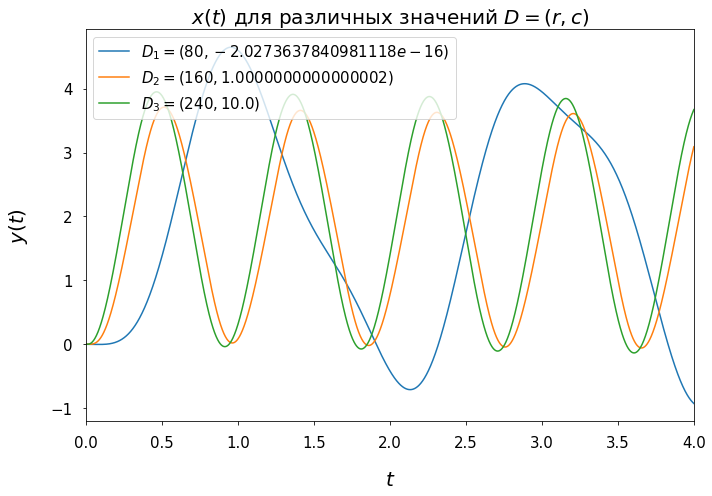

In [57]:
from numpy import arange, transpose

from scipy.integrate import odeint

import matplotlib.pyplot as plt

rs = [80, 160, 240]
dampers = []
for i in range(len(rs)):
    dampers.append(Damper(x[i], rs[i]))

h = 0.001
left = 0
right = 4 + h

points = arange(left, right, h)

initial_conditions = [0, 0]

values = []
for d in dampers:
    res, info = odeint(fun, initial_conditions, points, args=(d.r, d.c, K, M), atol=1e-10, full_output=True)
    y = transpose(res)[0]
    values.append(y)
    
axes = plt.figure(figsize=(10,7)).gca()

for i in range(len(dampers)):
    axes.plot(points, values[i], linewidth=1.5, label='$D_{i} = {d}$'.format(d=dampers[i], i=i+1))

axes.legend(loc='upper left', fontsize=15)
axes.set_xlabel('$t$', fontsize=20, labelpad=20)
axes.set_ylabel('$y(t)$', fontsize=20, labelpad=20)
axes.tick_params(labelsize=15, pad=10)
axes.set_xlim([left, right])
plt.title('$x(t)$ для различных значений $D = (r, c)$', fontsize=20)
plt.tight_layout()
plt.show()

Сравним качество демпферов $D_1$, $D_2$ и $D_3$. Из здравого смысла, демпфер считается хорошим, если хорошо обрабатывает неровности дороги, т.е. смещение центра тяжести автомобиля оказывается минимальным ($x(t) = x_{ideal}(t) = 0$)

Будем оценивать решения дифференциального уравнения, соответствующие различным демпферам, по двум критериям:

1) Среднеквадратическое отклонение полученного решения от $x_{ideal}(t)$

\begin{equation}
    \rho^2 = \sum_{k=1}^N (x(t_k) - x_{ideal}(t_k))^2 \rightarrow min
\end{equation}

2) Максимальная абсолютная разность $x(t)$ и $x_{ideal}(t)$ в точке из промежутка $[a, b]$

\begin{equation}
   \delta = max_{t \in [a, b]} \Big|x(t) - x_{ideal}(t) \Big| \rightarrow min
\end{equation}

In [58]:
from numpy import amax, array, fabs, zeros
    
def ro_quad(f1 : array, f2 : array):
    return ((f1 + f2) ** 2).sum()

def delta(f1 : array, f2 : array):
    return amax(fabs(f1 - f2))

for i in range(len(values)):
    l = len(values[i])
    s = ro_quad(values[i], zeros(l))
    dl = delta(values[i], zeros(l))
    print('D{i}: ro^2 = {s}, delta = {dl}'.format(i=i+1, s=s, dl=dl))

D1: ro^2 = 26020.911351898718, delta = 4.647877126643021
D2: ro^2 = 18708.949636212266, delta = 3.71003403219997
D3: ro^2 = 21777.92885009753, delta = 3.949934055528107


Получили, что демпфер $D_2$ оказался лучше остальных по обоим критериям сравнения. За ним идет $D_1$. И последний - $D_3$.

По графикам можно получить точно такие же выводы.

#### Оценка общей погрешности

Все вычисления производились при помощи функций из **python** библиотек **numpy** и **scipy**. Многие из них не предоставляют информацию о погрешности вычислений. Поэтому оценка будет грубой и будет производиться на основе тех данных, которые есть.

Абсолютная погрешность вычисления коэффициента упругости пружины $K$ равна $5.75 \cdot 10^{-15}$.
Абсолютная погрешность решения системы дифференциальных уравнений установлена вручную и равна $10^{-10}$.

Итого, грубая оценка абсолютной погрешности вычислений равна $10^{-10}$.

#### Оценка влияния на точность погрешности исходных данных.

Теперь будем варьировать значение $K$ на 5% и значение $M$ на 10%. Получим решения системы для $K \pm 5\%$ и $M \pm 10\%$ (4 варианта)

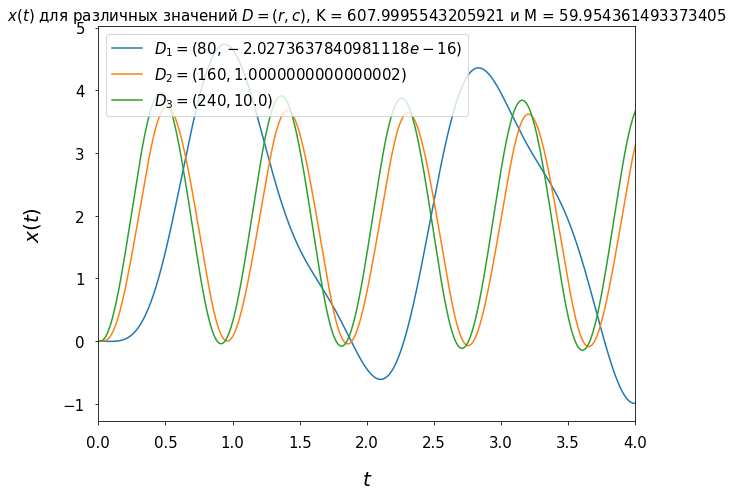

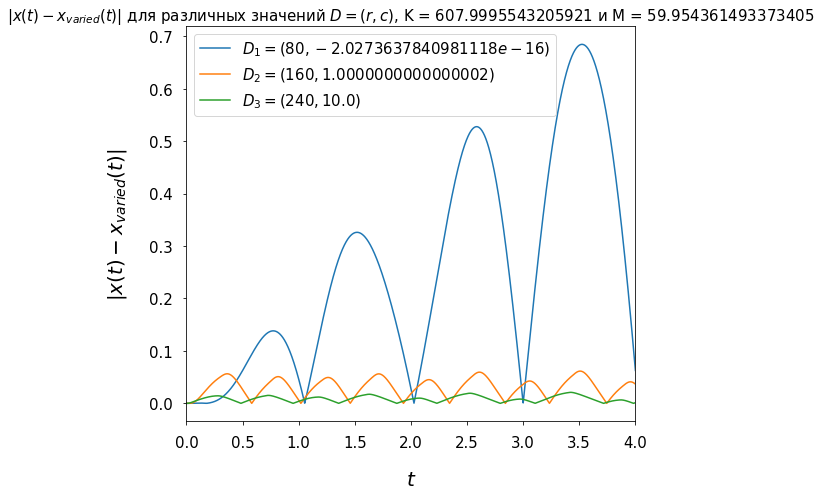

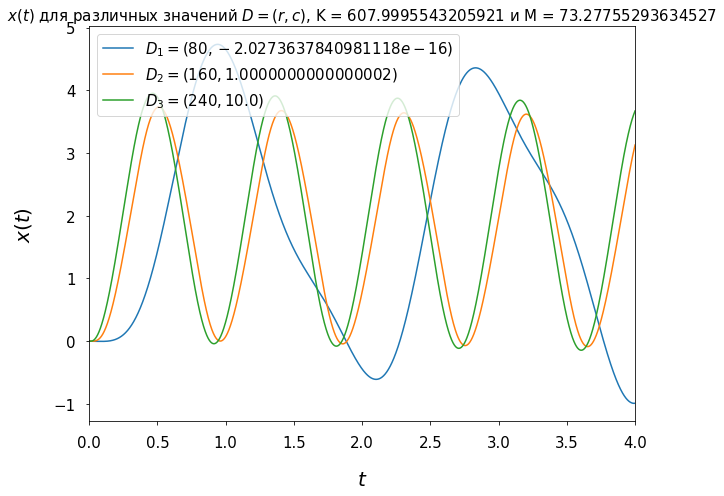

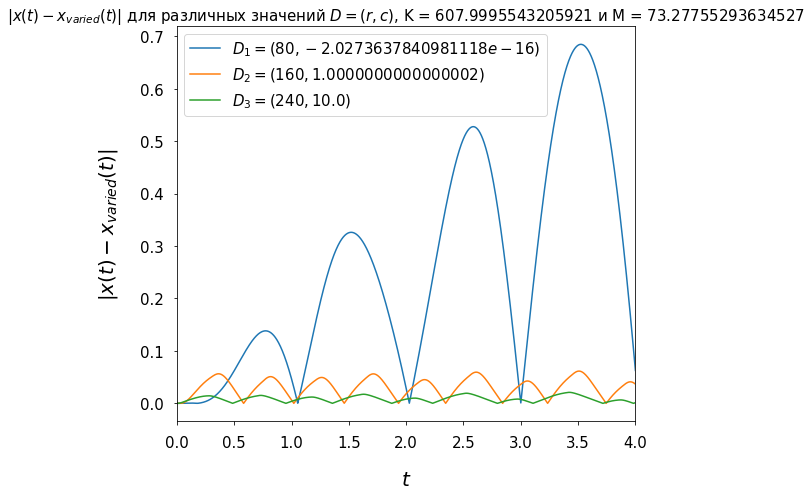

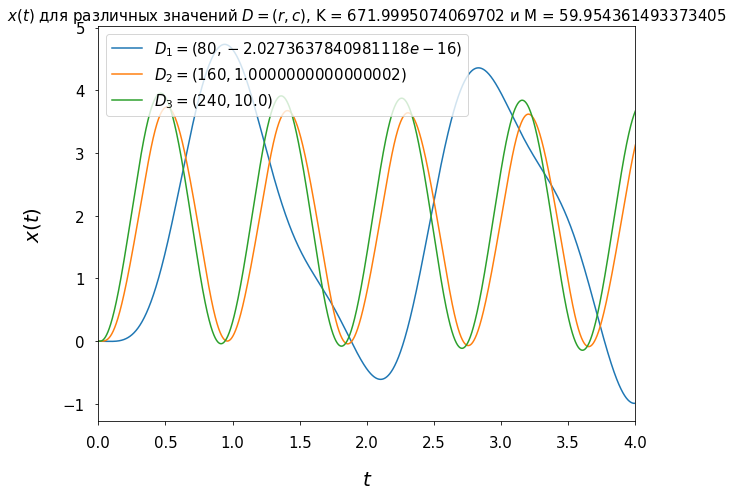

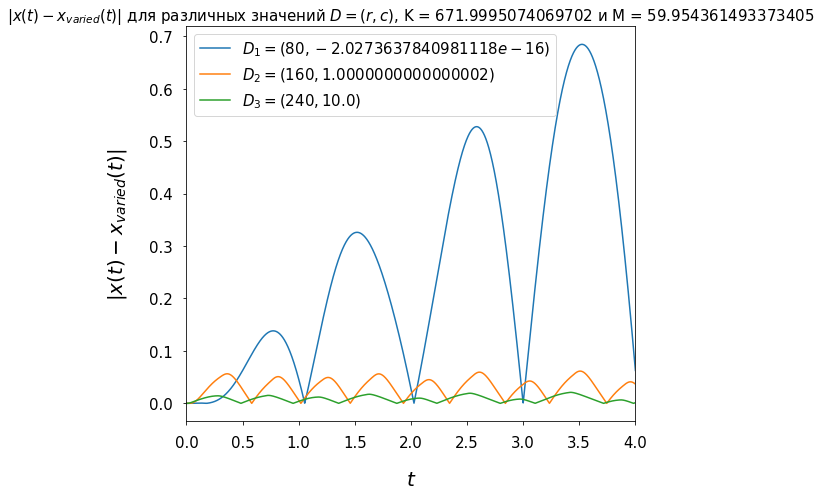

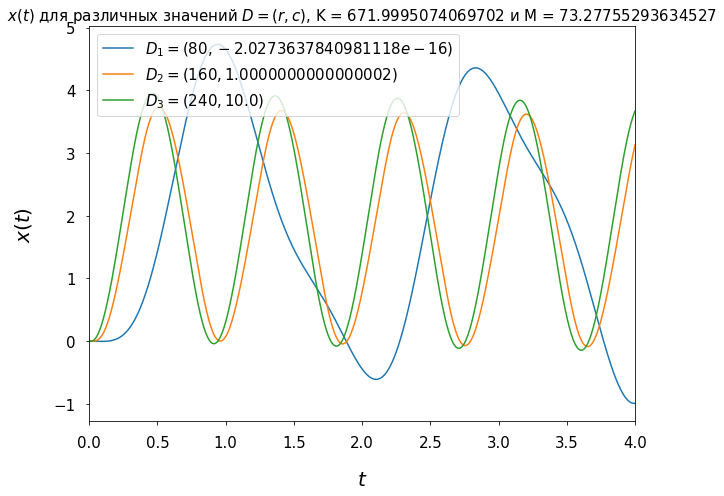

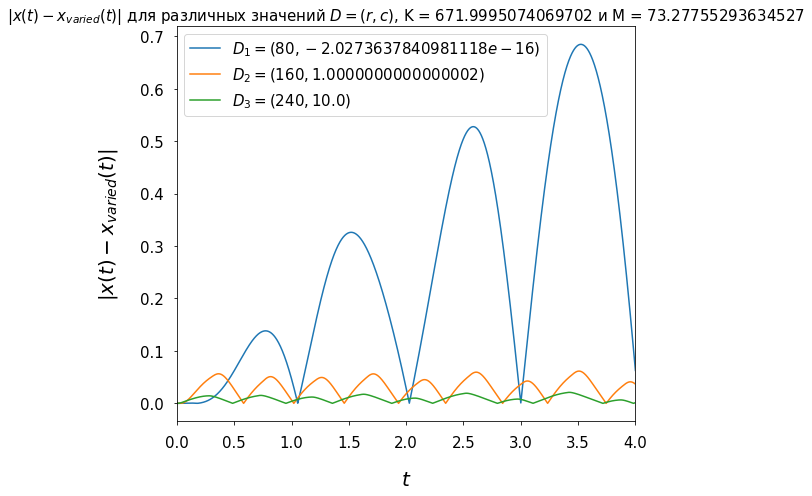

In [61]:
Ks = [K * 0.95, K * 1.05]
Ms = [M * 0.9, M * 1.1]

new_values = []
for k in Ks:
    for m in Ms:
        for d in dampers:
            res, info = odeint(fun, initial_conditions, points, args=(d.r, d.c, k, m), atol=1e-10, full_output=True)
            y = transpose(res)[0]
            new_values.append(y)
        
        axes = plt.figure(figsize=(10,7)).gca()
        for i in range(len(dampers)):
            axes.plot(points, new_values[i], linewidth=1.5, label='$D_{i} = {d}$'.format(d=dampers[i], i=i+1))

        axes.legend(loc='upper left', fontsize=15)
        axes.set_xlabel('$t$', fontsize=20, labelpad=20)
        axes.set_ylabel('$x(t)$', fontsize=20, labelpad=20)
        axes.tick_params(labelsize=15, pad=10)
        axes.set_xlim([left, right])
        plt.title('$x(t)$ для различных значений $D = (r, c)$, K = {k} и M = {m}'.format(k=k, m=m), fontsize=15)
        plt.tight_layout()
        
        dif = plt.figure(figsize=(10,7)).gca()
        for i in range(len(dampers)):
            dif.plot(points, fabs(values[i] - new_values[i]), linewidth=1.5, label='$D_{i} = {d}$'.format(d=dampers[i], i=i+1))
        dif.legend(loc='upper left', fontsize=15)
        dif.set_xlabel('$t$', fontsize=20, labelpad=20)
        dif.set_ylabel('$|x(t) - x_{varied}(t)|$', fontsize=20, labelpad=20)
        dif.tick_params(labelsize=15, pad=10)
        dif.set_xlim([left, right])
        plt.title('$|x(t) - x_{v}(t)|$ для различных значений $D = (r, c)$, K = {k} и M = {m}'.format(k=k, m=m, v='{varied}'), fontsize=15)
        plt.tight_layout()
        
        plt.show()

По графикам видно, что варьирование параметров $K$ и $M$, независимо от того, в большую сторону или в меньшую, наиболее сильно сказывается на демпфер $D_1$. Влияние варьирования параметров $K$ и $M$ на точность для демпферов $D_2$ и $D_3$ сильно меньше.